In [1]:
import supercell_core as sc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [32]:
gr = (sc.lattice()
            # Default unita are Angstrom coordinates
            .set_vectors([2.13, -1.23], [2.13, 1.23])
            .add_atom("C", [0, 0], unit=sc.Unit.Crystal)
            .add_atom("C", [2 / 3, 2 / 3], unit=sc.Unit.Crystal)
           )
ph = sc.read_POSCAR("data/POSCAR-P-NEW", atomic_species=["P"])
hbn = sc.read_POSCAR("data/POSCAR_hBN", atomic_species=["B", "N"])
ni = sc.read_POSCAR("data/POSCAR_Ni111", atomic_species=["Ni"])

bilayer = (sc.heterostructure()
           .set_substrate(gr)
           .add_layer(gr)
          )
trilayer = (sc.heterostructure()
           .set_substrate(gr)
           .add_layer(gr)
           .add_layer(gr)
          )
hgp = (sc.heterostructure()
      .set_substrate(hbn)
      .add_layer(gr)
      .add_layer(ph)
      )

hpg = (sc.heterostructure()
      .set_substrate(hbn)
      .add_layer(ph)
      .add_layer(gr)
      )

In [27]:
thetas = [[0], [0.4 * sc.DEGREE]]
tmp = hgp.opt(max_el=20, thetas=thetas)
res_0_04 = hgp.calc(M=tmp.M(), thetas=tmp.thetas())
res_0_04.superlattice().save_POSCAR("POSCAR_hgp_0_04")
res_0_04.max_strain()

MAGMOM flag: 2052*0


0.04098389728877475

In [23]:
thetas = [[3.8 * sc.DEGREE], [18.1 * sc.DEGREE]]
tmp = hpg.opt(max_el=20, thetas=thetas)
res_3_18 = hpg.calc(M=tmp.M(), thetas=tmp.thetas())
res_3_18.superlattice().save_POSCAR("POSCAR_hpg_3_18")
res_3_18.max_strain()

MAGMOM flag: 922*0


0.09177894628439413

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa3c6fb5c50>)

<Figure size 432x288 with 0 Axes>

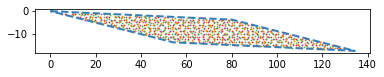

In [16]:
res_3_18.superlattice().draw()

In [17]:
# Temporary workaround for atom counts not being logged, Also, calculate thetas in deg instead of radians
def fix_log(df, *layers): 
    def cellsize(lattice):
        vecs = [v[0:2] for v in lattice.vectors()[0:2]]
        return np.abs(np.linalg.det(np.array(vecs)))
    
    df["atom_count"] = 0
    for lay in layers:
        df["atom_count"] += df["supercell_size"] / cellsize(lay) * len(lay.atoms())
        
    df["atom_count"] = np.round(df["atom_count"]).astype('int64')
    
    df["theta_0_deg"] = df["theta_0"] / sc.DEGREE
    if "theta_1" in df.columns:
        df["theta_1_deg"] = df["theta_1"] / sc.DEGREE
    
    return df

In [33]:
# Optimise hbn/gr/ph for Lmax=10 or Lmax=40 using fast algorithm
# Only for angles up to 30 degrees but in principle since there is no symmetry here,
# we should perform full search
res_hgp10 = hgp.opt(
    max_el=10,
    thetas=[np.arange(0, 30 * sc.DEGREE, 0.1 * sc.DEGREE), np.arange(0, 30 * sc.DEGREE, 0.1 * sc.DEGREE)],
    algorithm="fast",
    log=True
)

log_hgp10 = fix_log(res_hgp10.log, hbn, gr, ph)
log_hgp10.to_csv("hgp10.csv")
log_hgp10_head = log_hgp10.sort_values("max_strain").head(20)
log_hgp10_head.to_csv("hgp10_head.csv")

In [34]:
res_hgp40 = hgp.opt(
    max_el=40,
    thetas=[np.arange(0, 30 * sc.DEGREE, 0.1 * sc.DEGREE), np.arange(0, 30 * sc.DEGREE, 0.1 * sc.DEGREE)],
    algorithm="fast",
    log=True
)

log_hgp40 = fix_log(res_hgp40.log, hbn, gr, ph)
log_hgp40.to_csv("hgp40.csv")
log_hgp40_head = log_hgp40.sort_values("max_strain").head(20)
log_hgp40_head.to_csv("hgp40_head.csv")

In [36]:
# Save POSCARs
hgp.calc(M=res_hgp10.M(), thetas=res_hgp10.thetas()).superlattice().save_POSCAR("POSCAR10")
hgp.calc(M=res_hgp40.M(), thetas=res_hgp40.thetas()).superlattice().save_POSCAR("POSCAR40")

MAGMOM flag: 300*0
MAGMOM flag: 3804*0


[10.9, 29.900000000000002]

<Figure size 432x288 with 0 Axes>

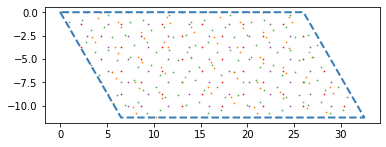

In [39]:
hgp.calc(M=res_hgp10.M(), thetas=res_hgp10.thetas()).superlattice().draw()
[x / sc.DEGREE for x in res_hgp10.thetas()]

In [47]:
hgp.calc(M=res_hgp10.M(), thetas=res_hgp10.thetas()).max_strain()

0.022797574474801068

In [22]:
# Optimise bilayer graphene using fast algorithm
res_bilayer = bilayer.opt(
    max_el=61,
    thetas=[np.arange(0, 30 * sc.DEGREE, 0.1 * sc.DEGREE)],
    algorithm="fast",
    log=True
)

log_bilayer = fix_log(res_bilayer.log, gr, gr)
log_bilayer.to_csv("bilayer_graphene.csv")

101 101


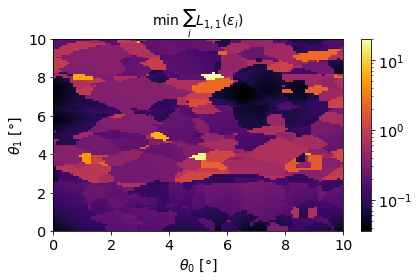

In [53]:
# Colormap
log4 = log_hgp10
log_subset = log4[(log4.theta_0 >= 0 * sc.DEGREE)
                  & (log4.theta_0 <= 10 * sc.DEGREE)
                  & (log4.theta_1 >= 0 * sc.DEGREE)
                  & (log4.theta_1 <= 10 * sc.DEGREE)]
side1 = len(log_subset.theta_0.unique())
side2 = len(log_subset.theta_1.unique())
print(side1, side2)
import matplotlib
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

plt.pcolormesh(log_subset.theta_0.unique() / sc.DEGREE,
               log_subset.theta_1.unique() / sc.DEGREE,
               np.array(log_subset.max_strain).reshape(side1, side2),
               cmap="inferno", norm=matplotlib.colors.LogNorm())
plt.colorbar()
plt.xlabel("$\\theta_0$ [°]", fontsize=14)
plt.ylabel("$\\theta_1$ [°]", fontsize=14)
plt.title("min $\sum_i L_{1, 1}(\\varepsilon_i)$", fontsize=14)
plt.tight_layout()
plt.savefig("hgp_map_Lmax10_2020_07_26.png")